# Noise2Void - 2D Model Training



In [5]:
# We import all our dependencies.
from n2v.models import N2VConfig, N2V
import numpy as np
from csbdeep.utils import plot_history
from n2v.utils.n2v_utils import manipulate_val_data
from n2v.internals.N2V_DataGenerator import N2V_DataGenerator
from matplotlib import pyplot as plt
import os


# Training Data Preparation
* Create directory for saving data.
* Create DataGenerator-object - helps load data and extract patches for training and validation.
* Load all .tif files
* Display shape of the images

In [6]:
data_directory = '/archive/bioinformatics/Danuser_lab/Fiolka/MicroscopeDevelopment/OPM/projection/Cardiomyocyte/200704/Cell8/training'

# create a folder for the results
if not os.path.isdir(os.path.join(data_directory,'denoised')):
    os.mkdir(os.path.join(data_directory,'denoised'))

# Generate DataGenerator
datagen = N2V_DataGenerator()

# Load .tifs
imgs = datagen.load_imgs_from_directory(directory = data_directory)

# Identify shape of the images.
print(imgs[0].shape,imgs[1].shape)

(1, 512, 2048, 1) (1, 512, 2048, 1)


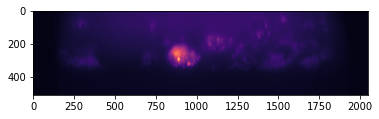

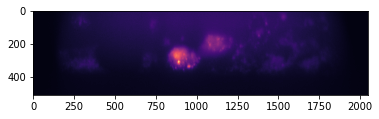

In [9]:
# Lets' look at the images.
# We have to remove the added extra dimensions to display them as 2D images.
plt.imshow(imgs[0][0,...,0], cmap='magma')
plt.show()

plt.imshow(imgs[1][0,...,0], cmap='magma')
plt.show()

In [10]:
# We will use the first image to extract training patches and store them in 'X'
patch_shape = (96,96)
X = datagen.generate_patches_from_list(imgs[:1], shape=patch_shape)

# We will use the second image to extract validation patches.
X_val = datagen.generate_patches_from_list(imgs[1:], shape=patch_shape)

# Patches are created so they do not overlap.
# (Note: this is not the case if you specify a number of patches. See the docstring for details!)
# Non-overlapping patches would also allow us to split them into a training and validation set 
# per image. This might be an interesting alternative to the split we performed above.



Generated patches: (840, 96, 96, 1)
Generated patches: (840, 96, 96, 1)
Generated patches: (840, 96, 96, 1)
Generated patches: (840, 96, 96, 1)
Generated patches: (840, 96, 96, 1)
Generated patches: (840, 96, 96, 1)
Generated patches: (840, 96, 96, 1)
Generated patches: (840, 96, 96, 1)
Generated patches: (840, 96, 96, 1)
Generated patches: (840, 96, 96, 1)
Generated patches: (840, 96, 96, 1)
Generated patches: (840, 96, 96, 1)
Generated patches: (840, 96, 96, 1)
Generated patches: (840, 96, 96, 1)
Generated patches: (840, 96, 96, 1)
Generated patches: (840, 96, 96, 1)
Generated patches: (840, 96, 96, 1)
Generated patches: (840, 96, 96, 1)
Generated patches: (840, 96, 96, 1)
Generated patches: (840, 96, 96, 1)
Generated patches: (840, 96, 96, 1)
Generated patches: (840, 96, 96, 1)
Generated patches: (840, 96, 96, 1)
Generated patches: (840, 96, 96, 1)
Generated patches: (840, 96, 96, 1)
Generated patches: (840, 96, 96, 1)
Generated patches: (840, 96, 96, 1)
Generated patches: (840, 96,

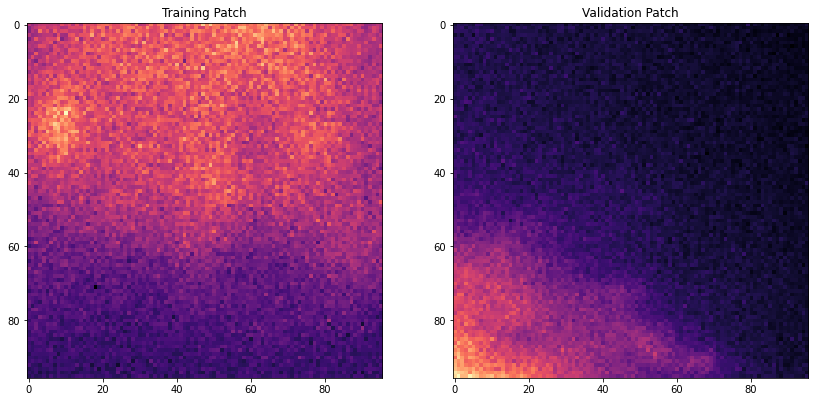

In [11]:
# Let's look at one of our training and validation patches.
plt.figure(figsize=(14,7))
plt.subplot(1,2,1)
plt.imshow(X[0,...,0], cmap='magma')
plt.title('Training Patch');
plt.subplot(1,2,2)
plt.imshow(X_val[0,...,0], cmap='magma')
plt.title('Validation Patch');


# Configure


Noise2Void comes with a special config-object, where we store network-architecture and training specific parameters. See the docstring of the N2VConfig constructor for a description of all parameters.

When creating the config-object, we provide the training data X. From X we extract mean and std that will be used to normalize all data before it is processed by the network. We also extract the dimensionality and number of channels from X.

Compared to supervised training (i.e. traditional CARE), we recommend to use N2V with an increased train_batch_size and batch_norm. To keep the network from learning the identity we have to manipulate the input pixels during training. For this we have the parameter n2v_manipulator with default value 'uniform_withCP'. Most pixel manipulators will compute the replacement value based on a neighborhood. With n2v_neighborhood_radius we can control its size.

Other pixel manipulators:

    normal_withoutCP: samples the neighborhood according to a normal gaussian distribution, but without the center pixel
    normal_additive: adds a random number to the original pixel value. The random number is sampled from a gaussian distribution with zero-mean and sigma = n2v_neighborhood_radius
    normal_fitted: uses a random value from a gaussian normal distribution with mean equal to the mean of the neighborhood and standard deviation equal to the standard deviation of the neighborhood.
    identity: performs no pixel manipulation

For faster training multiple pixels per input patch can be manipulated. In our experiments we manipulated about 0.198% of the input pixels per patch. For a patch size of 64 by 64 pixels this corresponds to about 8 pixels. This fraction can be tuned via n2v_perc_pix.

For Noise2Void training it is possible to pass arbitrarily large patches to the training method. From these patches random subpatches of size n2v_patch_shape are extracted during training. Default patch shape is set to (64, 64).

In the past we experienced bleedthrough artifacts between channels if training was terminated to early. To counter bleedthrough we added the single_net_per_channel option, which is turned on by default. In the back a single U-Net for each channel is created and trained independently, thereby removing the possiblity of bleedthrough.
Note: Essentially the network gets multiplied by the number of channels, which increases the memory requirements. If your GPU gets too small, you can always split the channels manually and train a network for each channel one after another.

to make this example notebook execute faster, we have set train_epochs to only 10.
For better results we suggest 100 to 200 train_epochs.


In [15]:
# train_steps_per_epoch is set to (number of training patches)/(batch size), like this each training patch 
# is shown once per epoch. 
number_epochs = 100
config = N2VConfig(X, unet_kern_size=3, 
                   train_steps_per_epoch=int(X.shape[0]/128), train_epochs=number_epochs, train_loss='mse', batch_norm=True, 
                   train_batch_size=128, n2v_perc_pix=0.198, n2v_patch_shape=(64, 64), 
                   n2v_manipulator='uniform_withCP', n2v_neighborhood_radius=5)

# Let's look at the parameters stored in the config-object.
vars(config)

{'means': ['198.67754'],
 'stds': ['85.598526'],
 'n_dim': 2,
 'axes': 'YXC',
 'n_channel_in': 1,
 'n_channel_out': 1,
 'unet_residual': False,
 'unet_n_depth': 2,
 'unet_kern_size': 3,
 'unet_n_first': 32,
 'unet_last_activation': 'linear',
 'unet_input_shape': (None, None, 1),
 'train_loss': 'mse',
 'train_epochs': 100,
 'train_steps_per_epoch': 6,
 'train_learning_rate': 0.0004,
 'train_batch_size': 128,
 'train_tensorboard': True,
 'train_checkpoint': 'weights_best.h5',
 'train_reduce_lr': {'factor': 0.5, 'patience': 10},
 'batch_norm': True,
 'n2v_perc_pix': 0.198,
 'n2v_patch_shape': (64, 64),
 'n2v_manipulator': 'uniform_withCP',
 'n2v_neighborhood_radius': 5,
 'structN2Vmask': None,
 'probabilistic': False}

In [16]:
# a name used to identify the model
model_name = 'n2v_2D'

# the base directory in which our model will live
basedir = os.path.join(data_directory,'models')

# Create a folder for the results
if not os.path.isdir(os.path.join(data_directory,'models')):
    os.mkdir(os.path.join(data_directory,'models'))
    
# We are now creating our network model.
model = N2V(config, model_name, basedir=basedir)



/home2/kdean/Desktop/GIT/external/n2v/n2v/models/n2v_standard.py:410: UserWarning: output path for model already exists, files may be overwritten: /endosome/archive/bioinformatics/Danuser_lab/Fiolka/MicroscopeDevelopment/OPM/projection/Cardiomyocyte/200704/Cell8/training/models/n2v_2D
  warnings.warn('output path for model already exists, files may be overwritten: %s' % str(self.logdir.resolve()))


# Training

Training the model will likely take some time. We recommend to monitor the progress with TensorBoard, which allows you to inspect the losses during training. Furthermore, you can look at the predictions for some of the validation images, which can be helpful to recognize problems early on.

You can start TensorBoard in a terminal from the current working directory with tensorboard --logdir=. Then connect to http://localhost:6006/ with your browser.

In [ ]:
# We are ready to start training now.
history = model.train(X, X_val)

8 blind-spots will be generated per training patch of size (64, 64).


Preparing validation data: 100%|██████████| 503160/503160 [12:53<00:00, 650.87it/s] 


Epoch 1/100
6/6 [==============================] - 5747s 958s/step - loss: 0.6252 - n2v_mse: 0.6252 - n2v_abs: 0.5769 - val_loss: 2.0470 - val_n2v_mse: 2.0470 - val_n2v_abs: 0.8459
Epoch 2/100
6/6 [==============================] - 5725s 954s/step - loss: 0.3558 - n2v_mse: 0.3558 - n2v_abs: 0.4464 - val_loss: 1.9758 - val_n2v_mse: 1.9758 - val_n2v_abs: 0.7704
Epoch 3/100
6/6 [==============================] - 5741s 957s/step - loss: 0.1664 - n2v_mse: 0.1664 - n2v_abs: 0.2946 - val_loss: 1.6655 - val_n2v_mse: 1.6655 - val_n2v_abs: 0.6530
Epoch 4/100
6/6 [==============================] - 5736s 956s/step - loss: 0.1325 - n2v_mse: 0.1325 - n2v_abs: 0.2615 - val_loss: 0.9074 - val_n2v_mse: 0.9074 - val_n2v_abs: 0.5496
Epoch 5/100
6/6 [==============================] - 5722s 954s/step - loss: 0.0992 - n2v_mse: 0.0992 - n2v_abs: 0.2192 - val_loss: 0.4936 - val_n2v_mse: 0.4936 - val_n2v_abs: 0.4632
Epoch 6/100
6/6 [==============================] - 5732s 955s/step - loss: 0.0907 - n2v_mse: 0.

### After training, lets plot training and validation loss.

['loss', 'lr', 'val_loss']


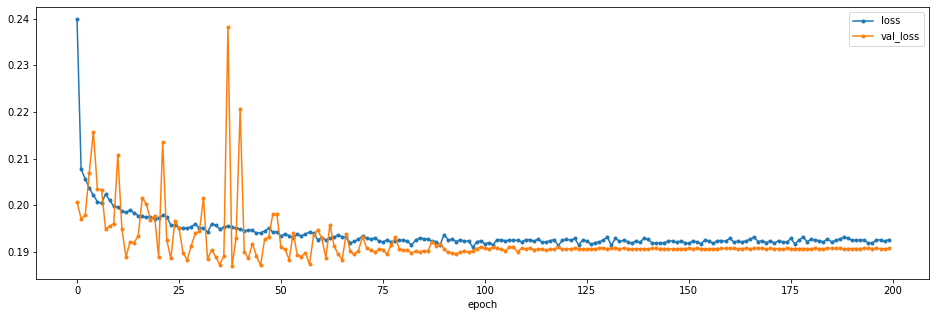

In [8]:
print(sorted(list(history.history.keys())))
plt.figure(figsize=(16,5))
plot_history(history,['loss','val_loss']);

# Compute PSNR to GT

In [9]:
groundtruth_data = np.load('data/BSD68_reproducibility_data/test/bsd68_groundtruth.npy', allow_pickle=True)

In [10]:
test_data = np.load('data/BSD68_reproducibility_data/test/bsd68_gaussian25.npy', allow_pickle=True)
# Note that we do not round or clip the noisy data to [0,255]
# If you want to enable clipping and rounding to emulate an 8 bit image format,
# uncomment the following line.
# test_data = np.round(np.clip(test_data, 0, 255.))

In [11]:
def PSNR(gt, img):
    mse = np.mean(np.square(gt - img))
    return 20 * np.log10(255) - 10 * np.log10(mse)

In [12]:
# Weights corresponding to the smallest validation loss
# Smallest validation loss does not necessarily correspond to best performance, 
# because the loss is computed to noisy target pixels.
model.load_weights('weights_best.h5')

In [13]:
pred = []
psnrs = []
for gt, img in zip(groundtruth_data, test_data):
    p_ = model.predict(img.astype(np.float32), 'YX');
    pred.append(p_)
    psnrs.append(PSNR(gt, p_))

psnrs = np.array(psnrs)

In [14]:
print("PSNR:", np.round(np.mean(psnrs), 2))

PSNR: 27.28


In [15]:
# The weights of the converged network. 
model.load_weights('weights_last.h5')

In [16]:
pred = []
psnrs = []
for gt, img in zip(groundtruth_data, test_data):
    p_ = model.predict(img.astype(np.float32), 'YX')
    pred.append(p_)
    psnrs.append(PSNR(gt, p_))

psnrs = np.array(psnrs)

In [17]:
print("PSNR:", np.round(np.mean(psnrs), 2))

PSNR: 27.71
